 # Scattered data interpolation.
 http://shihchinw.github.io/2018/10/data-interpolation-with-radial-basis-functions-rbfs.html

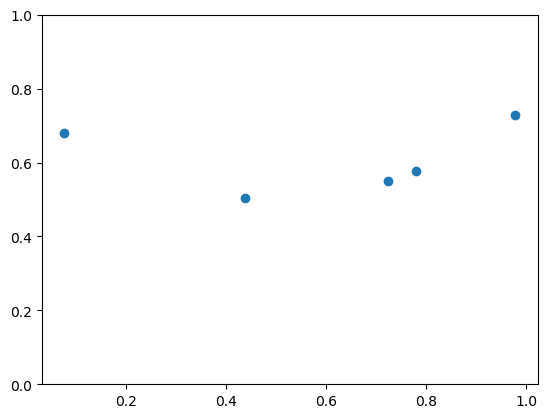

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# plt.rcParams['axes.prop_cycle']
num_samples = 5
fig_save_options = {'bbox_inches': 'tight', 'pad_inches': 0.1}

def generate_samples(sample_count, func, seed=None):
    np.random.seed(seed)
    xdata = np.random.random(sample_count)
    ydata = np.array([func(x) for x in xdata])
    return xdata, ydata

poly_funcs = [lambda x: 0.6, lambda x: 0.7 - 0.6 * x, lambda x: (x - 0.5) ** 2 + 0.5]
xdata, ydata = generate_samples(num_samples, poly_funcs[2], seed=7)
plt.ylim(0.0, 1.0)
plt.plot(xdata, ydata, 'o')
plt.show()


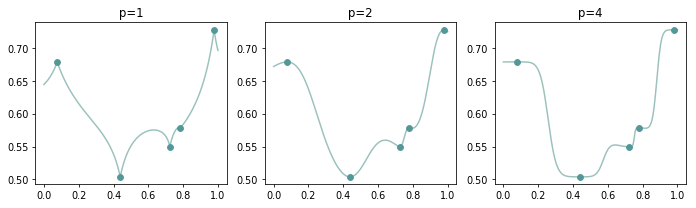

In [288]:
# Shepard's method
xsamples = np.linspace(0.0, 1.0, 256, endpoint=True)
xdiff = np.abs(xdata - xsamples[:, np.newaxis])  # Broadcast

plt.figure(figsize=(12, 3), dpi=70)
for i, p in enumerate([1, 2, 4]):
    weights = 1 / np.power(xdiff, p)
    sum_weights = np.sum(weights, axis=1, keepdims=True)
    weights /= sum_weights
    ysamples = weights.dot(ydata)

    plt.subplot(1, 3, i + 1)
    plt.title('p={}'.format(p))
    plt.plot(xsamples, ysamples, color='#9ac1bc')
    plt.plot(xdata, ydata, 'o', color='#539798')

# plt.savefig('images/shepard_interpolation.png', **fig_save_options)
plt.show()


In [289]:
class RBF(object):
    """1D RBF interpolant.
    """

    def __init__(self, centers, values, kernel, poly_deg=None, reg=0.0):
        """
        Args:
            centers: The spatial coordinates of data points.
            values: The values of data points.
            kernel: The radial basis function F: R -> R
            poly_deg: Max degrees of polynomial terms. 'None' means no polynomial terms.
            reg: The weight of regularizer.
        """

        sample_count = len(centers)
        Phi = np.empty((sample_count, sample_count))
        for i in range(sample_count):
            for j in range(i, sample_count):
                dist = linalg.norm(centers[i] - centers[j])
                Phi[i, j] = Phi[j, i] = kernel(dist)

        if poly_deg is None:
            if reg > 0.0:
                A = Phi.T.dot(Phi) + np.eye(sample_count) * reg
                b = Phi.T.dot(values)
            else:
                A = Phi
                b = values
        else:
            num_poly_terms = poly_deg + 1
            P = np.ones((sample_count, num_poly_terms))
            for d in range(1, poly_deg + 1):
                P[:, d] = np.power(centers, d)

            A = np.block([[Phi, P], [P.T, np.zeros((num_poly_terms, num_poly_terms))]])
            b = np.append(values, np.zeros(num_poly_terms))

            if reg > 0.0:
                b = A.T.dot(b)
                A = A.T.dot(A) + np.eye(sample_count + num_poly_terms) * reg

        self.centers = centers
        self.values = values
        self.kernel = kernel
        self.poly_deg = poly_deg
        self.coeffs = linalg.solve(A, b)

    def evaluate(self, centers, basis_idx=None):
        """Evaluate interpolated values of given sample centers.

        Args:
            centers: Array of sample locations in shape (N, 1).
            basis_idx: The index for specific basis function. Set 'None' to evaluate all basis functions.

        Results:
            An array in (N, 1) whose element is the evaluated value at the location.
        """
        dists = np.abs(centers[:, np.newaxis] - self.centers)
        Phi = self.kernel(dists)

        if basis_idx is None:
            coeffs = self.coeffs
        else:
            Phi = Phi[:, basis_idx]
            coeffs = self.coeffs[basis_idx]

        if self.poly_deg is None:
            return Phi.dot(coeffs)

        P = np.ones((len(centers), self.poly_deg + 1))
        for i in range(self.poly_deg):
            P[:, i + 1] = np.power(centers, i + 1)
        M = np.block([Phi, P])

        return M.dot(coeffs)

    def plot(self, segment_num=50, hide_ticks=False):
        """Plot interpolation result as 1D curve.
        """
        xdata = np.linspace(0.0, 1.0, segment_num, endpoint=True)
        ydata = self.evaluate(xdata)
        plt.ylim(0.0, 1.0)
        if hide_ticks:
            plt.xticks([])
            plt.yticks([])
        plt.plot(xdata, ydata, color='#9ac1bc')
        plt.plot(self.centers, self.values, 'o', color='#539798')

    def plot_basis(self, segment_num=50):
        """Plot all basis functions and the composed result.
        """
        # prop_cycle = plt.rcParams['axes.prop_cycle']
        # colors = prop_cycle.by_key()['color']
        colors = plt.cm.Paired(np.arange(len(self.centers) + 1))

        xdata = np.linspace(0.0, 1.0, segment_num, endpoint=True)
        for i, x in enumerate(self.centers):
            ydata = self.evaluate(xdata, i)
            plt.plot(xdata, ydata, color=colors[i])

            # Draw projection line to show the corresponding
            y = self.kernel(0.0) * self.coeffs[i]
            plt.plot([x, x], [y, self.values[i]], color='#CCCCCC', linestyle='--')
            plt.plot([x], [y], 'o', color=colors[i])

        # Draw composed curve
        ydata = self.evaluate(xdata)
        plt.plot(xdata, ydata, color=colors[-1])
        plt.plot(self.centers, self.values, 'o', color=colors[-1])  # Draw the data points of each center


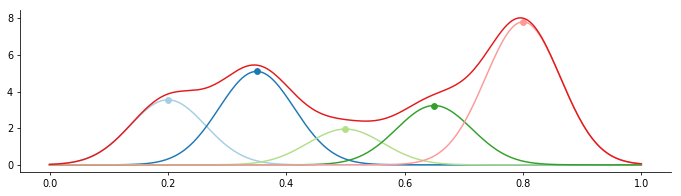

In [290]:
# # Plot basis sumation with Gaussian basis
def gaussian(x, sigma=0.1):
    return np.exp(-x * x / np.power(sigma, 2.0))

np.random.seed(3)
x_data = np.linspace(0.2, 0.8, num_samples)
y_data = 10 ** np.random.random(num_samples)

plt.figure(figsize=(12, 3), dpi=70)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

colors = plt.cm.Paired(np.arange(num_samples + 1))
xdiff = np.abs(xsamples - x_data[:, np.newaxis])
values = gaussian(xdiff, 0.09)
for i in range(num_samples):
    x = x_data[i]
    y = y_data[i]
    plt.plot(x, y, 'o', color=colors[i])
    plt.plot(xsamples, values[i] * y, color=colors[i])

values_sum = np.sum(values * y_data[:, np.newaxis], axis=0)
plt.plot(xsamples, values_sum, color=colors[-1])
# plt.savefig('images/sum_of_gaussian_basis.png', **fig_save_options)


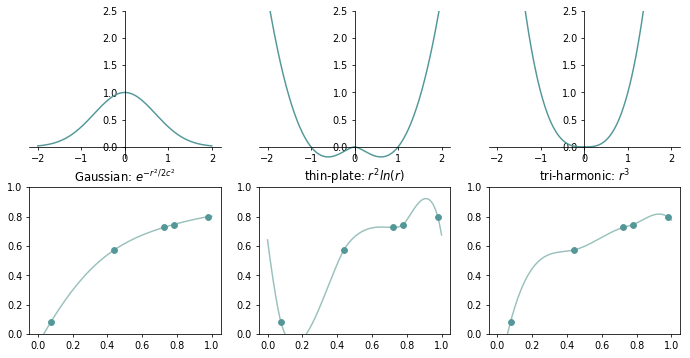

In [291]:
# Interpolate with various kernel functions.
def thinplate(r):
    return r * r * np.log(np.maximum(1e-8, r))

def triharmonic(r):
    return r * r * r

def filmc_curve(x):
    """The fitted ACES tone mapping curve by Krzysztof Narkowicz.
    https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
    """
    return (x * (2.51 * x + 0.03)) / (x * (2.43 * x + 0.59) + 0.14)

plt.figure(figsize=(12, 6), dpi=70)
kernels = [lambda x: gaussian(x, 1.0), thinplate, triharmonic]
kernel_names = [r'Gaussian: $e^{-r^2/2c^2}$', 'thin-plate: $r^2 ln(r)$', 'tri-harmonic: $r^3$']

x_data, y_data = generate_samples(5, filmc_curve, seed=7)
xsamples = np.linspace(-2.0, 2.0, 256, endpoint=True)
for i, kernel in enumerate(kernels):
    ax = plt.subplot(2, 3, i + 1)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position((('data', 0)))
    ax.spines['left'].set_position((('data', 0)))
    plt.ylim(-0.2, 2.5)

    y_values = kernels[i](np.abs(xsamples))
    plt.plot(xsamples, y_values, color='#539798')

    plt.subplot(2, 3, i + 4)
    plt.title(kernel_names[i])
    rbf = RBF(x_data, y_data, kernel, poly_deg=None)
    rbf.plot(256)

# plt.savefig('images/rbf_with_various_kernels.png', **fig_save_options)


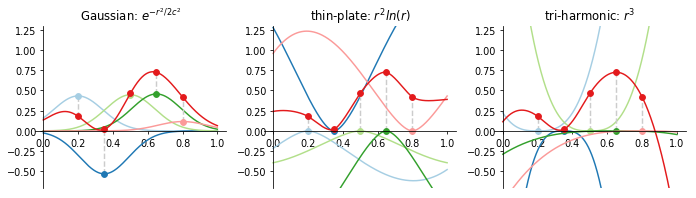

In [292]:
# Basis summation
plt.figure(figsize=(12, 3), dpi=70)
np.random.seed(11)
x_data = np.linspace(0.2, 0.8, num_samples)
y_data = np.random.random(num_samples)
kernels = [lambda x: gaussian(x, 0.2), thinplate, triharmonic]

for i, kernel in enumerate(kernels):
    ax = plt.subplot(1, 3, i + 1)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position((('data', 0)))
    ax.spines['left'].set_position((('data', 0)))
    ax.set_ylim(-0.7, 1.3)
    plt.title(kernel_names[i])
    rbf = RBF(x_data, y_data, kernel)
    rbf.plot_basis(512)

# plt.savefig('images/rbf_composition_with_various_kernels.png', **fig_save_options)


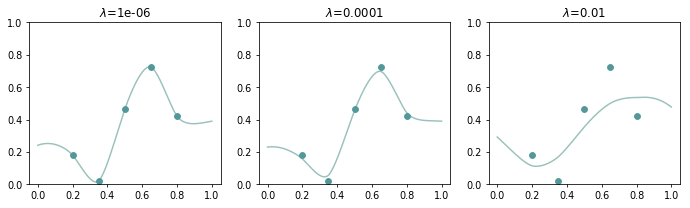

In [293]:
# Thin-plate interpolation with regularization.
plt.figure(figsize=(12, 3), dpi=70)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    reg = pow(10.0, -6 + i * 2)
    plt.title(r'$\lambda$={}'.format(reg))
    rbf = RBF(x_data, y_data, thinplate, poly_deg=None, reg=reg)
    rbf.plot(256)

#plt.savefig('images/rbf_thinplate_and_regularization.png', **fig_save_options)


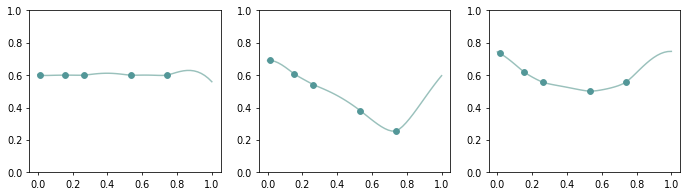

In [294]:
# Generate samples from constant, linear and quadratic functions.
sample_values = []
for f in poly_funcs:
    sample_values.append(generate_samples(num_samples, f, 12))

# Thin-plate interpoolation without polynomial terms.
plt.figure(figsize=(12, 3), dpi=70)
for i, (xs, ys) in enumerate(sample_values):
    plt.subplot(1, 3, i + 1)
    rbf = RBF(xs, ys, thinplate)
    rbf.plot()

# plt.savefig('images/thinplate_rbf.png', **fig_save_options)


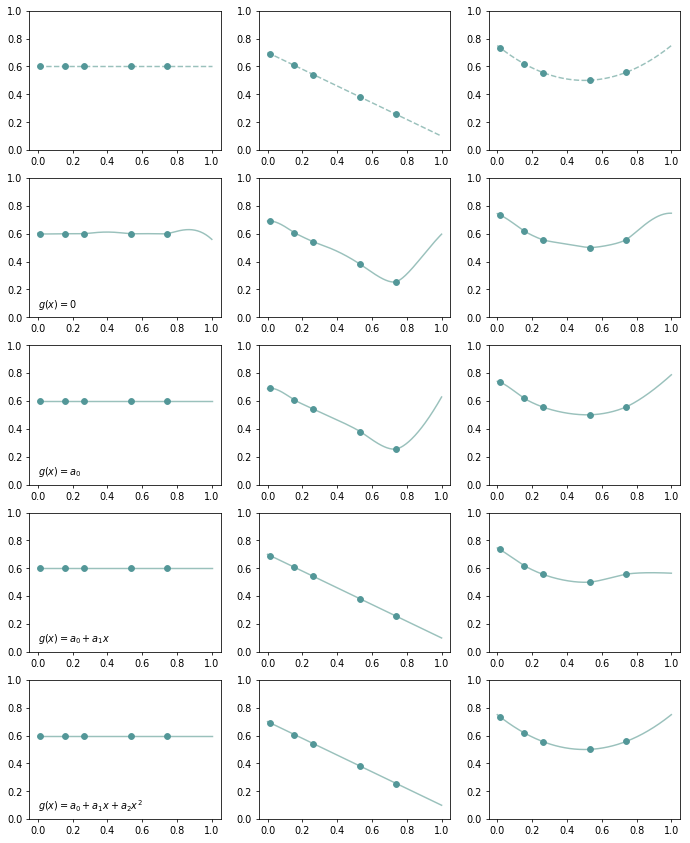

In [295]:
# RBF with constant polynomial
plt.figure(figsize=(12, 15), dpi=70)
text_arrays = [r'$g(x)=a_0$', r'$g(x)=a_0+a_1 x$', r'$g(x)=a_0+a_1 x+a_2 x^2$']

for i, (xs, ys) in enumerate(sample_values):
    plt.subplot(5, 3, i + 1)
    plt.ylim(0.0, 1.0)
    # plt.xticks([])
    # plt.yticks([])
    xc = np.linspace(0.0, 1.0, 64, endpoint=True)
    yc = [poly_funcs[i](x) for x in xc]
    plt.plot(xc, yc, '--', color='#9ac1bc')
    plt.plot(xs, ys, 'o', color='#539798')

    plt.subplot(5, 3, i + 4)
    rbf = RBF(xs, ys, thinplate)
    if i == 0:
        plt.text(0, 0.07, r'$g(x)=0$')
    rbf.plot(256)

    for d in range(3):
        plt.subplot(5, 3, i + 7 + d * 3)
        if i == 0:
            plt.text(0, 0.07, text_arrays[d])
        rbf = RBF(xs, ys, thinplate, poly_deg=d)
        rbf.plot(256)

# plt.savefig('images/rbf_polynomial_extensions.png', **fig_save_options)